Load, read and explore the power quality data at 30 minute intervals for April 2021.
The data was curated from the provided power quality data in 5 mins interval, divided into 13 months from Oct’20 to Nov’21, of roughly 1060 meters  with 60 target class meters. There were 13 files in total for each month in csv format. 
Data description :https://drive.google.com/file/d/1yKr4kDnf6YBJOpfGZSF5584scGk0ko0M/view?usp=sharing


1.Load data 

In [366]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from glob import glob
import datetime
import yaml

In [367]:
def load_config(config_path):
    if os.path.exists(config_path):
        config = yaml.load(open(config_path), Loader=yaml.FullLoader)
    else:
        
        raise FileNotFoundError("File does not exist.")
    return config

In [368]:
root_path = Path().cwd().parent
config = load_config(root_path / 'energyhub/config.yaml')
root_path
config # dictionary 

{'INPUT_PATH': 'c:/Users/gouri/working/energyhub',
 'METERS_LIST': 'EV_training_meters_list.xlsx',
 'CONSUMPTION_FILES': ['consumption_training_data_sep21.csv',
  'consumption_training_data_oct21.csv'],
 'POWER_FILES': ['power_quality_training_data_apr21.csv'],
 'OUTPUT_PATH': 'c:/Users/gouri/working/energyhub',
 'LOG_FILE_PATH': 'c:/Users/gouri/working/energyhub'}

In [369]:
# loading config files and params
config = load_config(root_path / 'energyhub/config.yaml')
INPUT_PATH = config['INPUT_PATH']#get value 
OUTPUT_PATH = config['OUTPUT_PATH']#get value 
METERS_FILE = config['METERS_LIST']#get value 
CONSUMPTION_FILES = config['CONSUMPTION_FILES']#get value 
POWER_FILES = config['POWER_FILES']#get value 

In [370]:
#from Max's notebook 
all_files = glob(os.path.join(INPUT_PATH,'power_quality_30min.csv' ))
dataframes = []
for filename in all_files:
    df = pd.read_csv(filename, header=0, infer_datetime_format=True, parse_dates=['interval_ts_local'], index_col=['interval_ts_local'])
    dataframes.append(df)
power_data = pd.concat(dataframes, axis=0, ignore_index=False)


In [371]:
print(power_data.shape)

(1442, 14)


This is data for one meter. meter #396.
The power quality data consists of 1,442 observations and 14 variables.
The data is indexed by timestamp
We have added year, month, day, hour, minute, second, week and day of week variables to help us with creating subsets of the data for further analysis 


In [372]:
power_data.sample(5)

,channel_cd,meter_id,voltage_lvt,amps_lct,power_factor_pf,number_of_phases,year,month,day,hour,minute,second,week,dayofweek
interval_ts_local,,,,,,,,,,,,,,
2021-04-12 15:00:00+10:00,a,396.0,242.560000,1.001425,-0.684167,1.0,2021.0,4.0,12.0,15.0,12.5,0.0,15.0,0.0
2021-04-03 12:30:00+11:00,a,396.0,244.305000,0.416816,-0.718500,1.0,2021.0,4.0,3.0,12.0,42.5,0.0,13.0,5.0
2021-04-10 02:30:00+10:00,a,396.0,241.741667,0.417183,-0.667833,1.0,2021.0,4.0,10.0,2.0,42.5,0.0,14.0,5.0
2021-04-14 09:30:00+10:00,a,396.0,242.785000,1.815193,-0.111500,1.0,2021.0,4.0,14.0,9.0,42.5,0.0,15.0,2.0
2021-04-24 14:00:00+10:00,a,396.0,241.551667,1.286054,-0.382500,1.0,2021.0,4.0,24.0,14.0,12.5,0.0,16.0,5.0


The meter id, channel_cd, number_of_phases, year and month are redundant variables nad can be dropped for this analysis 

In [373]:
power_data = power_data.drop(['meter_id', 'channel_cd', 'year', 'month', 'number_of_phases'], axis =1)

We do not have any missing values 

In [376]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in the DataFrame :\n",
      power_data.isnull().sum())

 
Count total NaN at each column in the DataFrame :
 voltage_lvt        0
amps_lct           0
power_factor_pf    0
day                0
hour               0
minute             0
second             0
week               0
dayofweek          0
dtype: int64


Using histograms to understand the data distribution 
Are the distributions Gaussian or any other distribution?
the variables of interest are Voltage, Current and Poer Factor 
The measured value vs the number of occurrences
Which phenomena produce what kind of distribution ?


Distribution of voltage is near Gaussian 


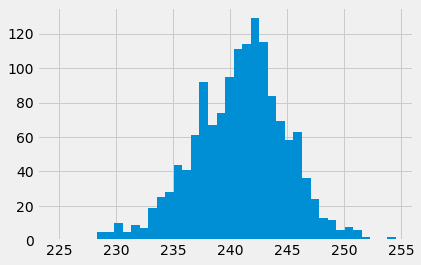

In [377]:
import matplotlib.pyplot as plt
x = power_data['voltage_lvt']
plt.hist(x, bins = 40)
plt.show()
 
# Show plot


Distribution of current readings is skewed to the right 
There are few readings where a high current is drawn and more where a low current is drawn


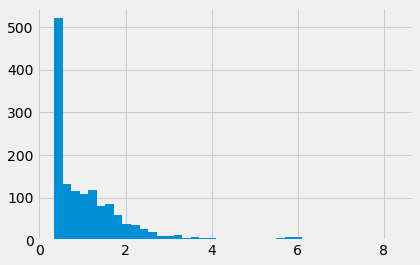

In [379]:
x = power_data['amps_lct']
plt.hist(x, bins = 40)
plt.show()

The power factor distribution seems to have many peaks but there are more readings with a low power factor ( closer to -1 ) and there is no clear distribution of readings with a medium or high power factor  ( 0 to 1 )

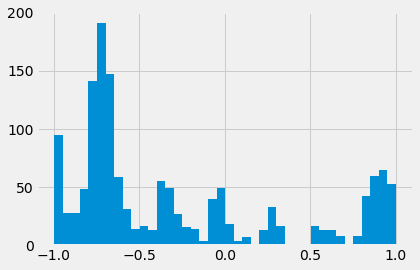

In [378]:
x = power_data['power_factor_pf']
plt.hist(x, bins = 40)
plt.show()

In [380]:
#n = number of observations = 100
#Range = maximum value – minimum value = 91 – 1 = 90
# of intervals =  √n = √100 = 10
#Width of intervals =  Range / (# of intervals) = 90/10 = 9
import math
n = len(power_data)
r = power_data['voltage_lvt'].max() - power_data['voltage_lvt'].min()
i = math.sqrt(n)
w = r/i 
print("Number of observations:", n, "Voltage range :", r, "intervals:", i, "width:", w)


Number of observations: 1442 Voltage range : 29.951666666666654 intervals: 37.97367509209505 width: 0.7887481681461395


In [381]:
power_data['voltage_lvt'].describe()

count    1442.000000
mean      240.868531
std         4.091582
min       224.581667
25%       238.109583
50%       241.179167
75%       243.471667
max       254.533333
Name: voltage_lvt, dtype: float64

There are 1442 readings for meter 396. The mean value of voltage is 240.87
The average deviation in voltage from the mean is 4.10
Q1 is 238.10 25 % of the readings  have a voltage less than 238.10 
Q3 is 243.47 75% of the readings have a voltage less than 243.47
Using IQR: an outlier is any data point that is 1.5 times the IQR above Q3 or below Q1.
IQR is 5.37 
The normal data range with lower limit is Q1–1.5*IQR and upper limit is Q3+1.5*IQR.


In [382]:
#outlier 
(243.47-238.10)*1.5


8.055000000000007

In [383]:
n_lower = 238.10- 1.5*(8.06)
n_upper = 243.47 + 1.5*(8.06)

print("Normal data range with lower limit:", n_lower, "Normal data range with upper limit", n_upper)

Normal data range with lower limit: 226.01 Normal data range with upper limit 255.56


In [262]:
#get any data points outside this limit 
#power_data['outlier'] = power_data['voltage_lvt'].apply(lambda x : True if (x > n_upper and x < n_lower) else False)
power_data['outlier'] = power_data['voltage_lvt'].apply(lambda x : x > n_upper or x < n_lower)

In [384]:
#listofoutliers = power_data['voltage_lvt'].apply(list(filter(lambda x : x > n_upper and x < n_lower)))
#convert voltage series to lis t
listofoutliers = power_data['voltage_lvt'].tolist()
listofoutliers = list(filter(lambda x : x > n_upper or x < n_lower, listofoutliers))

In [385]:
listofoutliers
#only one outlier 

[224.58166666666668]

We only have one outlier. For now , we will ingore it but can handle it in the next interation

Some definitions
Active power is the name given to the power consumed by an electrical circuit doing something useful
It is measured in watts 
Reactive power is the term used to describe the power drawn by an electrical circuit to do things that are not productive
Apparent power is the total power passing through an electrical circuit, both active and reactive. It is a significant value to consider when designing and rating an electrical circuit. The measurement of apparent power is volt-ampere (VA). 

The alternating current in an electrical circuit can lead, lag, or match the voltage, and this has an impact on the power factor
Power factor is simply expressed as the ratio of active power to apparent power. The closer this ratio is to one, the more of the apparent power is active 
power supplied to the load, and the more efficient the electrical circuit is. The more the power factor leads or lags, the larger the deviation from unity power 
factor, and the greater the power requirements for the electrical circuit.

We create a new variable to hold the power factor for every observation over a certain threshold ( between .8 and 1 )
If True, the poer factor is within the range
If False, the powe factor is not within the range 


In [386]:
#what are the rows when power factor is close to unity ( .9 to 1 )
power_data['pf_unity'] = power_data['power_factor_pf'].apply(lambda x : .8 < x <=1)

In [387]:
power_data.head()

,voltage_lvt,amps_lct,power_factor_pf,day,hour,minute,second,week,dayofweek,pf_unity
interval_ts_local,,,,,,,,,,
2021-04-01 00:00:00+11:00,240.300000,0.638608,-0.317667,1.0,0.0,12.5,0.0,13.0,3.0,False
2021-04-01 00:30:00+11:00,241.006667,0.446645,-0.450833,1.0,0.0,42.5,0.0,13.0,3.0,False
2021-04-01 01:00:00+11:00,241.646667,0.470529,-0.778833,1.0,1.0,12.5,0.0,13.0,3.0,False
2021-04-01 01:30:00+11:00,240.741667,0.417800,-0.704667,1.0,1.0,42.5,0.0,13.0,3.0,False
2021-04-01 02:00:00+11:00,241.161667,0.447880,-0.753500,1.0,2.0,12.5,0.0,13.0,3.0,False


In [388]:
power_data.index.min()

datetime.datetime(2021, 4, 1, 0, 0, tzinfo=tzoffset(None, 39600))

In [389]:
power_data.index.max()

datetime.datetime(2021, 4, 30, 23, 30, tzinfo=tzoffset(None, 36000))

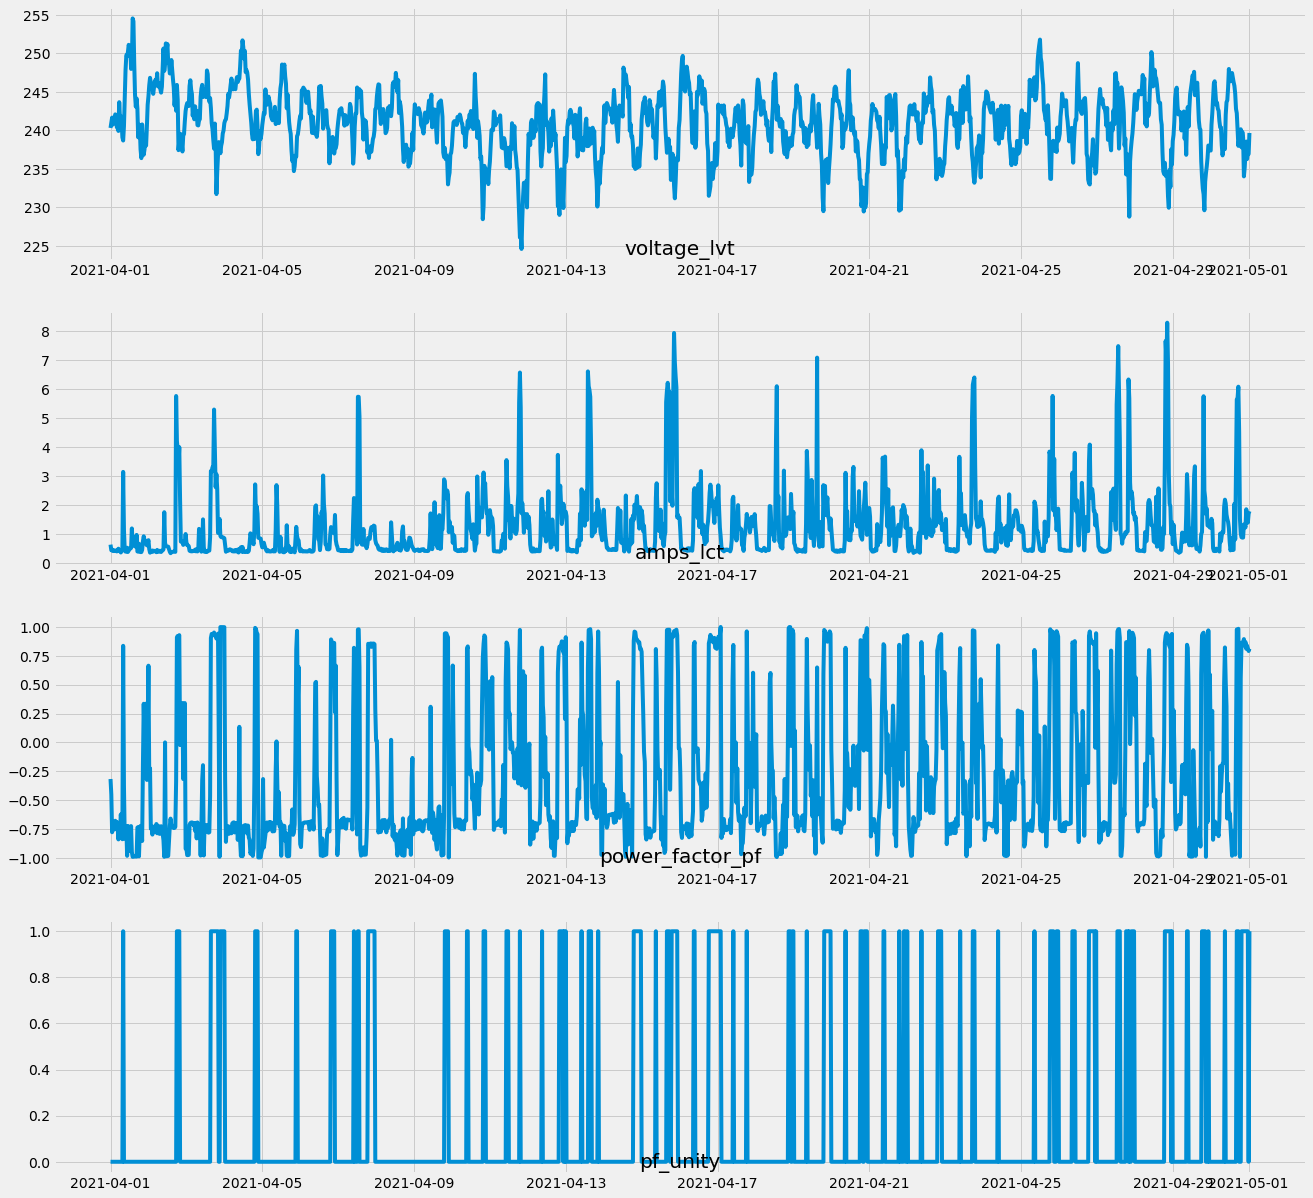

In [397]:
import matplotlib.pyplot as plt
cols_list = ['voltage_lvt', 'amps_lct', 'power_factor_pf','pf_unity']
cols1 = power_data.drop(['day', 'hour','minute','second', 'week','dayofweek'], axis = 1)
plt.figure(figsize=(20, 20))
for i in range(len(cols1.columns)):
	plt.subplot(len(cols1.columns), 1, i+1)
	name = cols1.columns[i]
	plt.plot(cols1[name])
	plt.title(name, y=0)
plt.show()


The power factor peaks unity for several time spans
Identifying the time spans and patterns when the power factor is 1 wil help us identify when there is availability on the meter
conducting a  high level of the month on voltage, amps and power factor , at 30 minute intervals , zooming in and focusing on one variable at a time 


array([<AxesSubplot:xlabel='interval_ts_local'>,
       <AxesSubplot:xlabel='interval_ts_local'>,
       <AxesSubplot:xlabel='interval_ts_local'>], dtype=object)

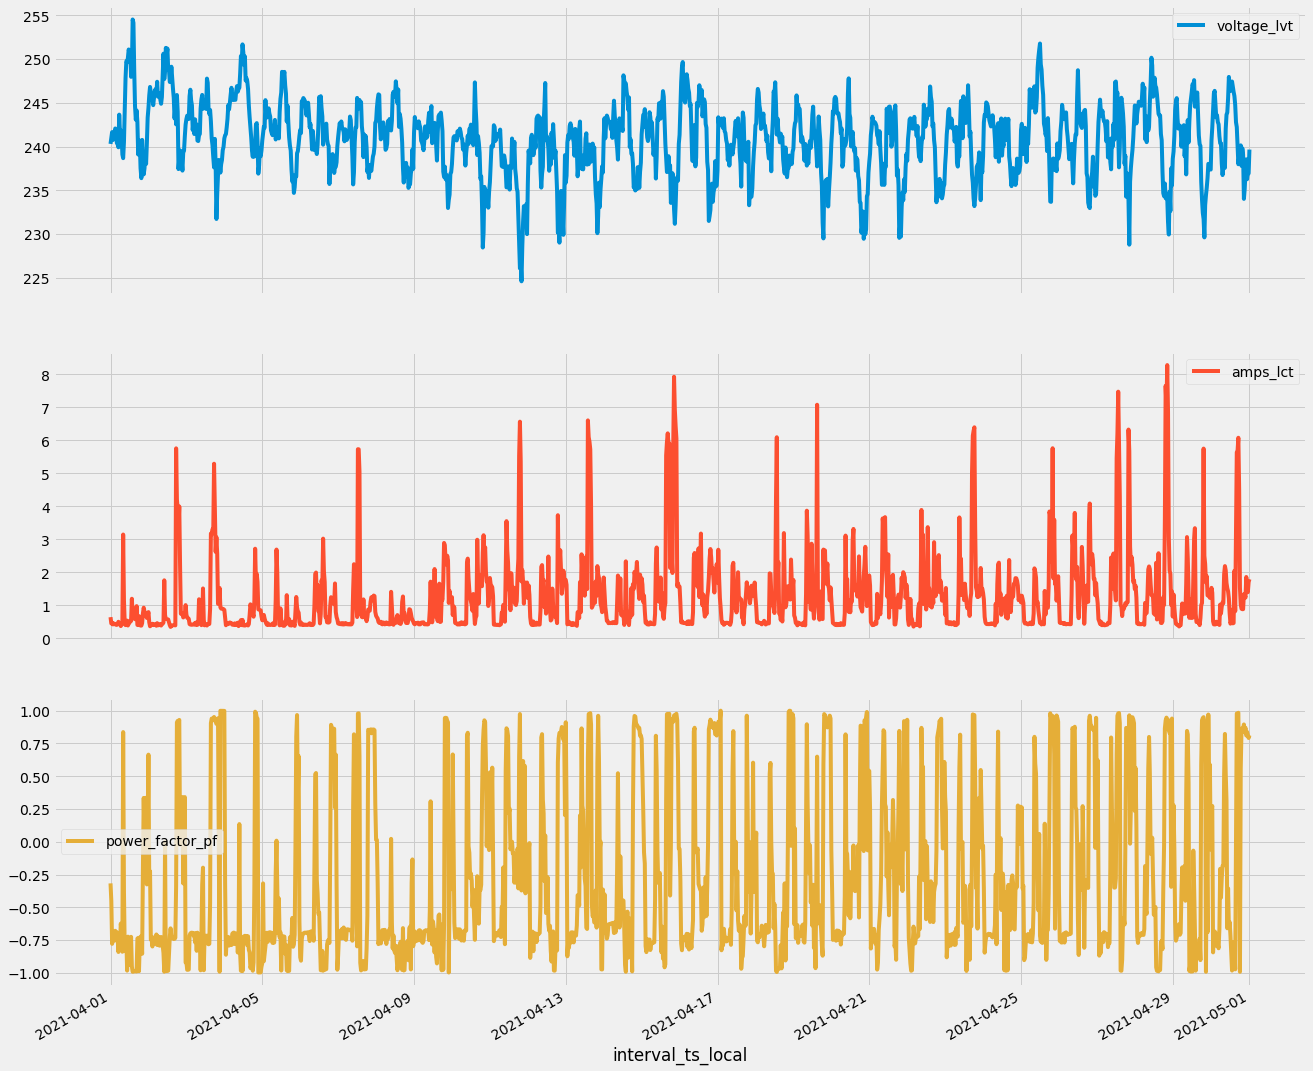

In [398]:
plt.style.use("fivethirtyeight")
cols1.plot(subplots=True, figsize=(20, 20))

In [399]:
cols1.head()

,voltage_lvt,amps_lct,power_factor_pf,pf_unity
interval_ts_local,,,,
2021-04-01 00:00:00+11:00,240.300000,0.638608,-0.317667,False
2021-04-01 00:30:00+11:00,241.006667,0.446645,-0.450833,False
2021-04-01 01:00:00+11:00,241.646667,0.470529,-0.778833,False
2021-04-01 01:30:00+11:00,240.741667,0.417800,-0.704667,False
2021-04-01 02:00:00+11:00,241.161667,0.447880,-0.753500,False


We can see the fluctuations in voltage, current and power factor values over time

Zooming in on a single day, day 1 

In [400]:
cols2 = power_data.loc[power_data['day'] == 1.0]

In [401]:
cols2.head()

,voltage_lvt,amps_lct,power_factor_pf,day,hour,minute,second,week,dayofweek,pf_unity
interval_ts_local,,,,,,,,,,
2021-04-01 00:00:00+11:00,240.300000,0.638608,-0.317667,1.0,0.0,12.5,0.0,13.0,3.0,False
2021-04-01 00:30:00+11:00,241.006667,0.446645,-0.450833,1.0,0.0,42.5,0.0,13.0,3.0,False
2021-04-01 01:00:00+11:00,241.646667,0.470529,-0.778833,1.0,1.0,12.5,0.0,13.0,3.0,False
2021-04-01 01:30:00+11:00,240.741667,0.417800,-0.704667,1.0,1.0,42.5,0.0,13.0,3.0,False
2021-04-01 02:00:00+11:00,241.161667,0.447880,-0.753500,1.0,2.0,12.5,0.0,13.0,3.0,False


Examining the voltage readings for day 1 

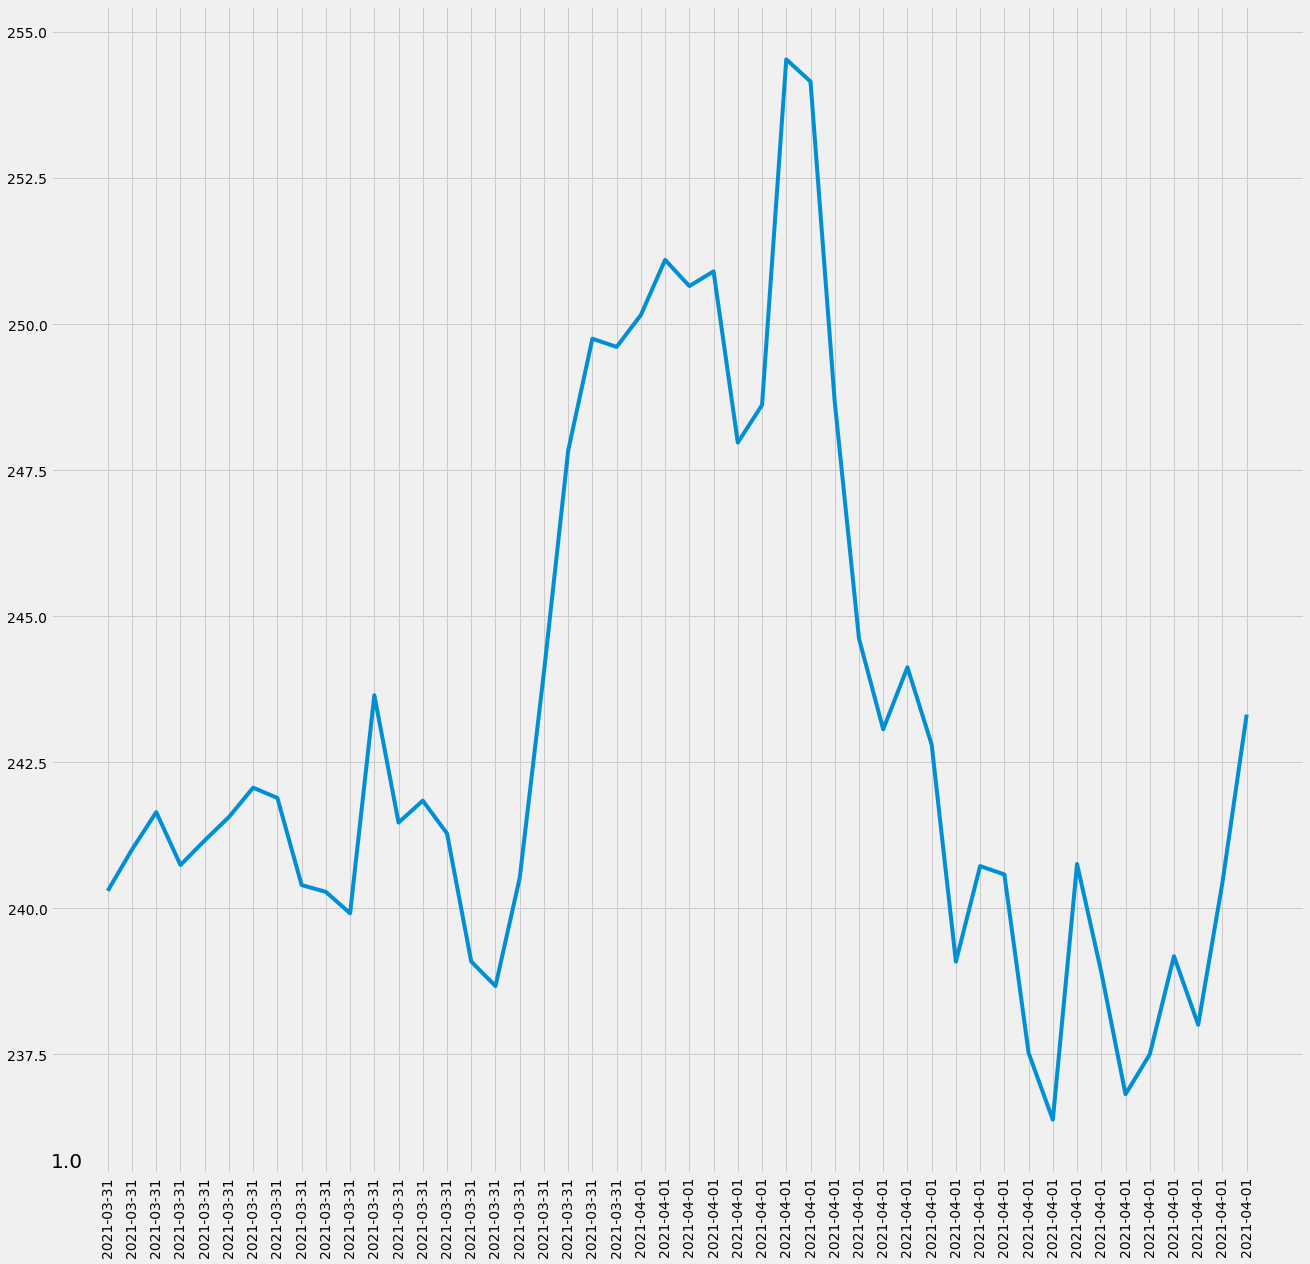

In [402]:
#zoom in on the voltage 
days = [1.0]
plt.figure(figsize=(20, 20))
for i in range(len(days)):
	# prepare subplot
	ax = plt.subplot(len(days), 1, i+1)
	# determine the year to plot
	day = days[i]
	# get all observations for the year
	#result = cols[str(day)]
	result = power_data.loc[power_data['day'] == day]
	# plot the active power for the year
	plt.plot(result['voltage_lvt'])
	plt.xticks(result.index, rotation ='vertical')
	# add a title to the subplot
	plt.title(str(day), y=0, loc='left')
plt.show()

What is the significance of voltage fluctuations over time ?

Examining the current fluctuations over time for day 1 

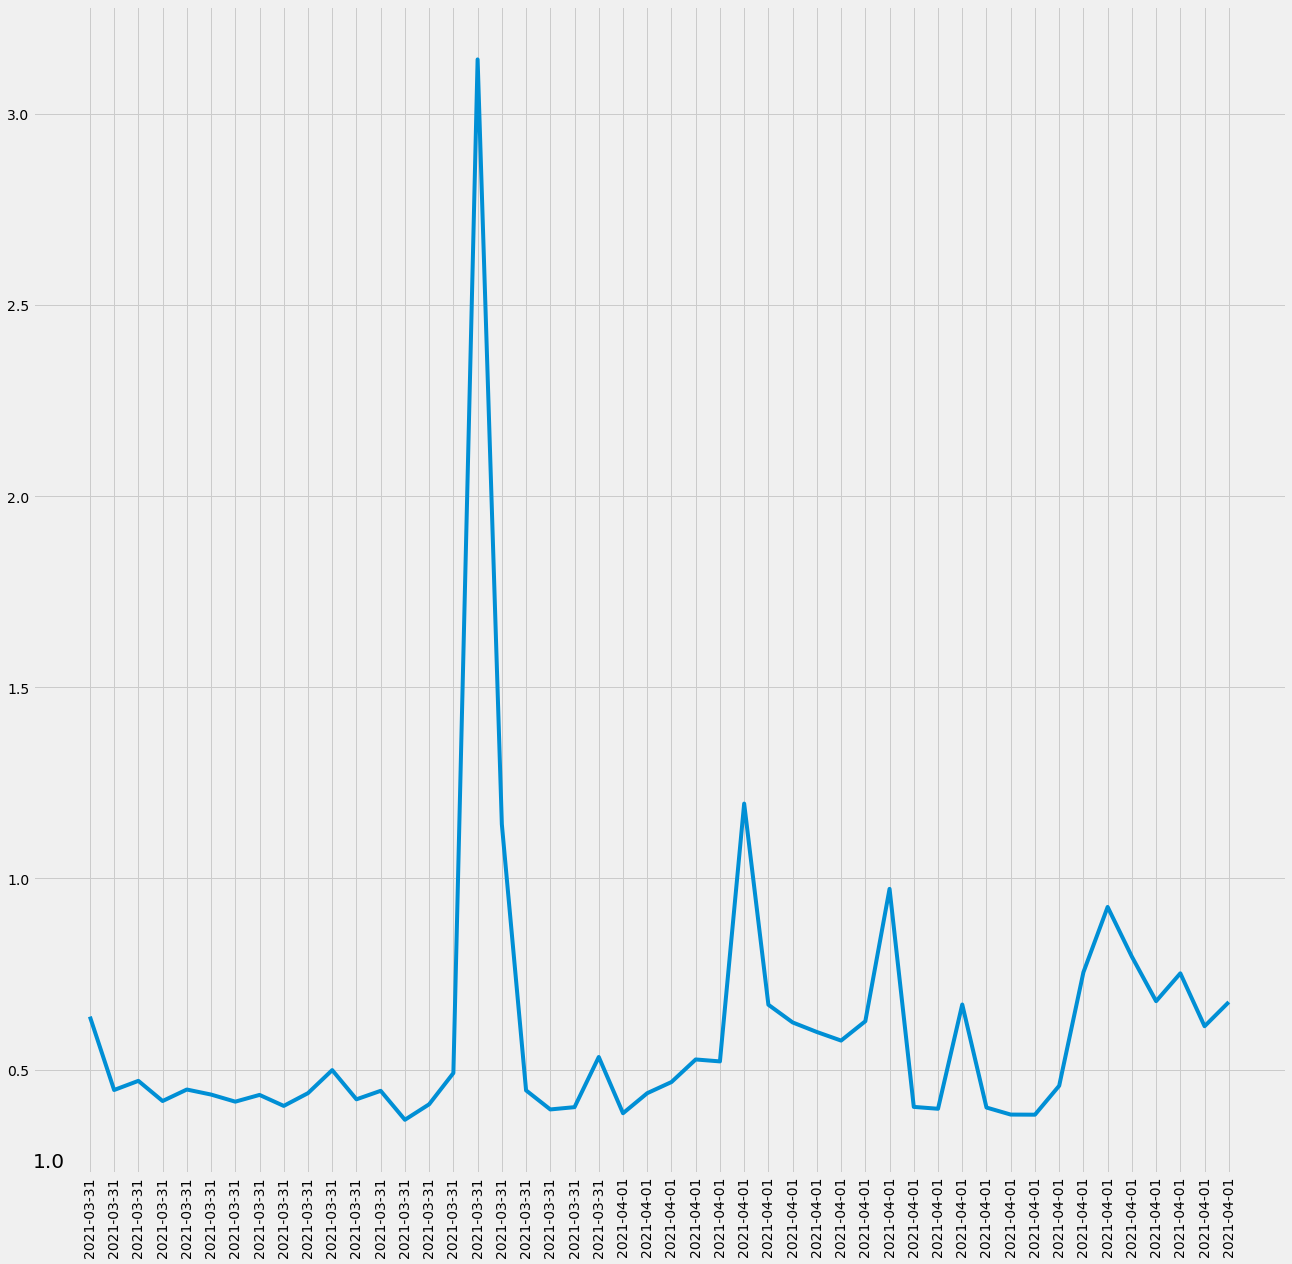

In [403]:
#zoom in on the current
days = [1.0]
plt.figure(figsize=(20, 20))
for i in range(len(days)):
	# prepare subplot
	ax = plt.subplot(len(days), 1, i+1)
	# determine the year to plot
	day = days[i]
	# get all observations for the year
	#result = cols[str(day)]
	result = power_data.loc[power_data['day'] == day]
	# plot the active power for the year
	plt.plot(result['amps_lct'])
	plt.xticks(result.index, rotation ='vertical')
	# add a title to the subplot
	plt.title(str(day), y=0, loc='left')
plt.show()

What is the significance of current fluctuations over time ?

Examining the power factor readings for day 1 

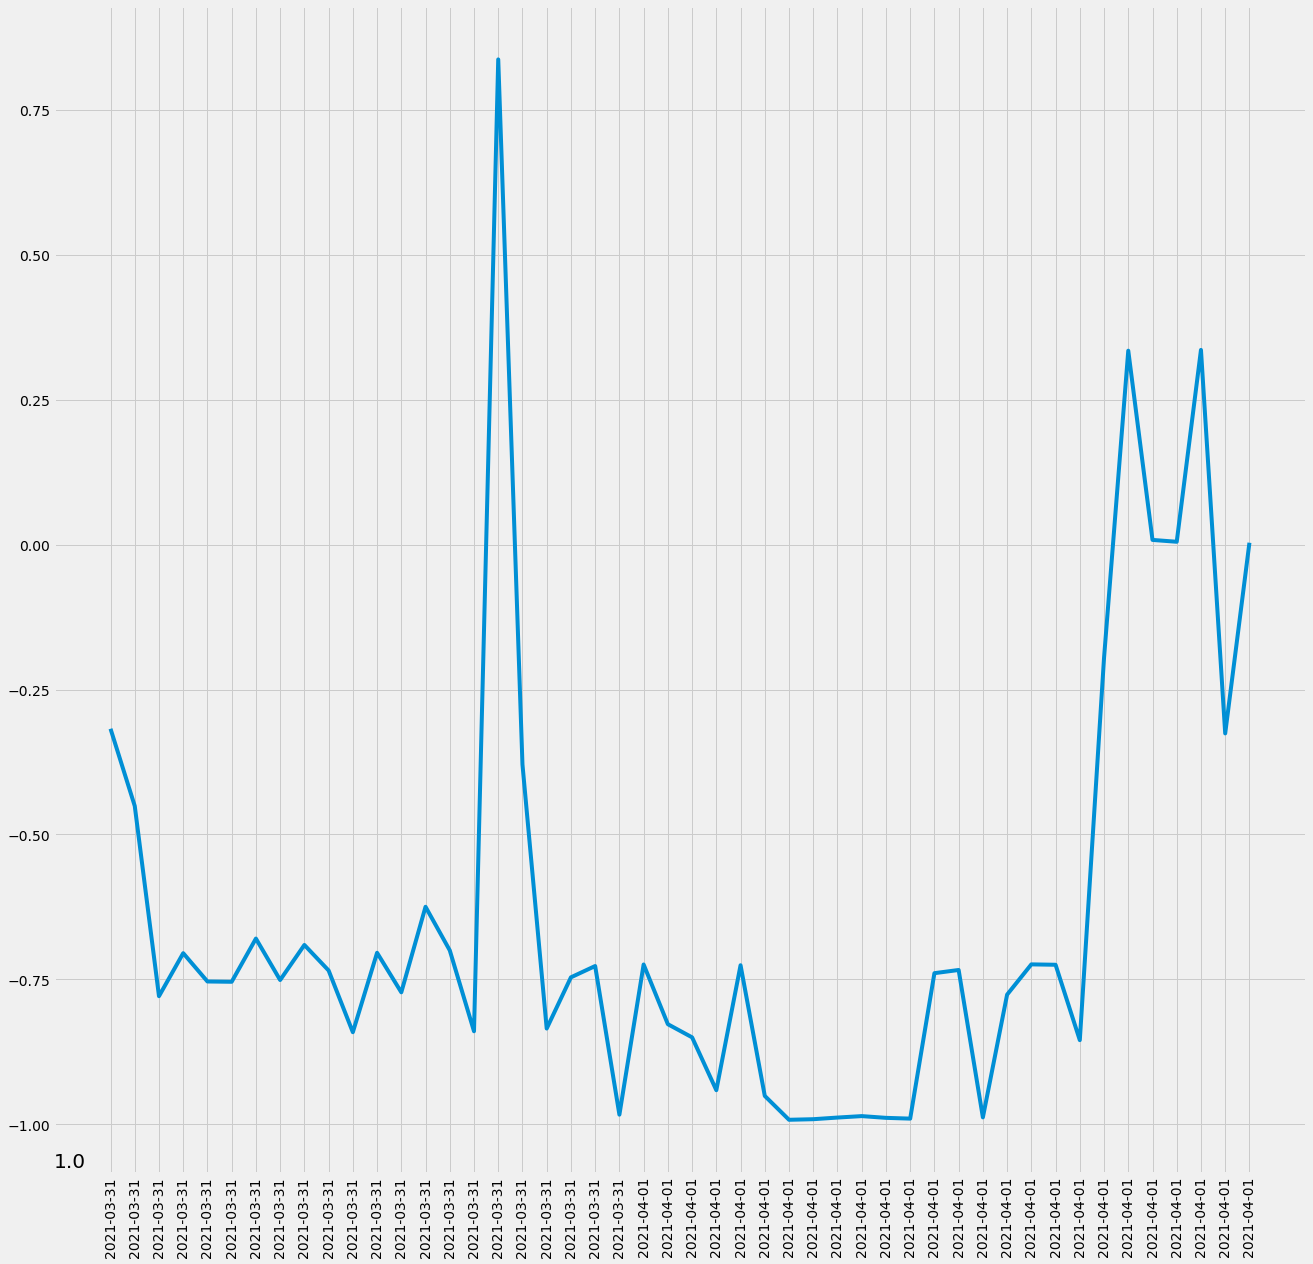

In [404]:
#zoom in on the powerfactor
days = [1.0]
plt.figure(figsize=(20, 20))
for i in range(len(days)):
	# prepare subplot
	ax = plt.subplot(len(days), 1, i+1)
	# determine the year to plot
	day = days[i]
	# get all observations for the year
	#result = cols[str(day)]
	result = power_data.loc[power_data['day'] == day]
	# plot the active power for the year
	plt.plot(result['power_factor_pf'])
	plt.xticks(result.index, rotation ='vertical')
	# add a title to the subplot
	plt.title(str(day), y=0, loc='left')
plt.show()

There is more availability when the power factor is close to unity 
Identifying these time spans may help 